In [1]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

print("imported libraries")

imported libraries


In [2]:
from torch import cuda

# Setup device
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

Running on device: cuda


In [3]:
# Charger le dataset
input_csv = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\dataset\text\text_lang_detector.csv"
df = pd.read_csv(input_csv, sep=";")
df.head()

,sentence,is_not_french
0,Y a -t -il un moyen d 'aller de Montreux -Vieu...,0
1,I would like to travel from culoz to buswiller...,1
2,He lied when he said he didn 't like her .,1
3,?N |ajOLIY6 ;DOM 'mKavLZZnkAi,0
4,a (c }sMyu7 /97 . [ -IA @m k0rN0U,0


In [4]:
# Prétraiter les données
def preprocess_data(df):
    X = df['sentence']
    y = df['is_not_french']
    return X, y

X, y = preprocess_data(df)

In [5]:
# Diviser les données en ensembles d'entraînement et de test
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

In [6]:
# Tokenization des phrases et création de séquences
max_words = 10000
max_len = 100  # Longueur maximale des séquences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [7]:
# Construction du modèle LSTM
model = Sequential()

# Couche d'embedding
embedding_dim = 50
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))

# Couche LSTM
model.add(LSTM(128, activation='tanh', return_sequences=False))

# Dropout pour éviter le sur-apprentissage
model.add(Dropout(0.2))

# Couche fully connected
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Sortie binaire (French vs Not French)

# Compilation du modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\Seed\anaconda3\envs\travel_order\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
# Entraînement du modèle
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/5
32544/32544 ━━━━━━━━━━━━━━━━━━━━ 1179s 36ms/step - accuracy: 0.9931 - loss: 0.0195 - val_accuracy: 0.9980 - val_loss: 0.0069
Epoch 2/5
32544/32544 ━━━━━━━━━━━━━━━━━━━━ 1204s 37ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accuracy: 0.9980 - val_loss: 0.0066
Epoch 3/5
32544/32544 ━━━━━━━━━━━━━━━━━━━━ 1269s 39ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9981 - val_loss: 0.0066
Epoch 4/5
32544/32544 ━━━━━━━━━━━━━━━━━━━━ 1041s 32ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9982 - val_loss: 0.0066
Epoch 5/5
32544/32544 ━━━━━━━━━━━━━━━━━━━━ 932s 29ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9981 - val_loss: 0.0067


In [9]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)

8136/8136 ━━━━━━━━━━━━━━━━━━━━ 78s 10ms/step


In [10]:
# Évaluation du modèle
print("### Classification Report ###")
print(classification_report(y_test, y_pred))

print("### Accuracy ###")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

### Classification Report ###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    183170
           1       1.00      0.99      1.00     77179

    accuracy                           1.00    260349
   macro avg       1.00      1.00      1.00    260349
weighted avg       1.00      1.00      1.00    260349

### Accuracy ###
Accuracy: 0.9980


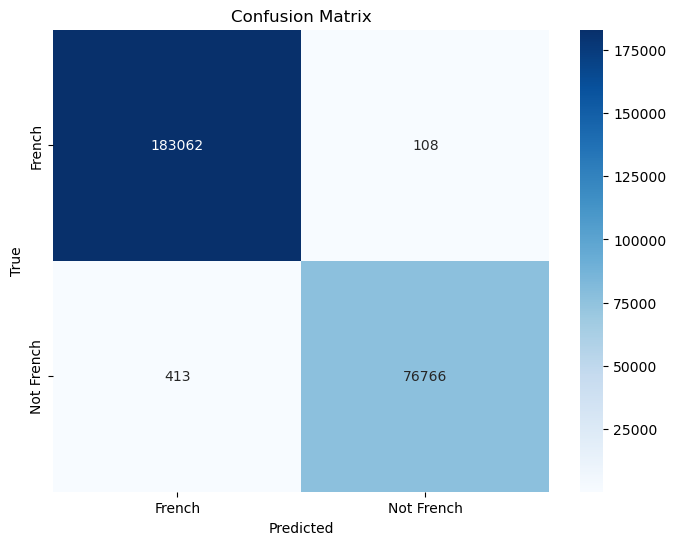

In [11]:
# Matrice de confusion
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["French", "Not French"], yticklabels=["French", "Not French"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

In [13]:
# Sauvegarde du modèle
model_path = r"C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\lstm_lang_detector_e5.h5"
model.save(model_path)

print(f"Modèle sauvegardé dans : {model_path}")

Modèle sauvegardé dans : C:\Users\Seed\Projects\Travel-Order-Resolver\ai\nlp\models\text_classification\lstm_lang_detector_e5.h5


In [18]:
# Exemple de prédictions avec de nouvelles phrases
new_sentences = [
    "I would like to go to the station.",
    "Voglio andare alla stazione.",
    "je veux partir de Marseille à Paris",
    "Ich möchte zum Bahnhof gehen.",
    "Quiero morir",
    "Je veux aller à la gare.",
    "XAtybzgdsughzt  hcvzbzt  98ezzg hn(è_è)",
    " ghdsjbxasxhbdgh  ugzxcayy 8454czcg vhuaè-_è_",
    " jdsbgzcnehgcnzh zbcnj",
    " cgdhjznc 465zevy-é(&bhebhz)",
    "I would like to drink tequila",
    "75269862 29569 595+ 29 2 9 4"
]

# Prétraiter les nouvelles phrases
new_sentences_seq = tokenizer.texts_to_sequences(new_sentences)
new_sentences_pad = pad_sequences(new_sentences_seq, maxlen=max_len)

# Prédictions
predictions = model.predict(new_sentences_pad)
predictions = (predictions > 0.5).astype(int)

# Affichage des résultats
results = pd.DataFrame({
    'Sentence': new_sentences,
    'Predicted Language': ['French' if prediction == 0 else 'Not French' for prediction in predictions]
})

import IPython
IPython.display.display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


,Sentence,Predicted Language
0,I would like to go to the station.,Not French
1,Voglio andare alla stazione.,Not French
2,je veux partir de Marseille à Paris,French
3,Ich möchte zum Bahnhof gehen.,Not French
4,Quiero morir,Not French
5,Je veux aller à la gare.,French
6,XAtybzgdsughzt hcvzbzt 98ezzg hn(è_è),Not French
7,ghdsjbxasxhbdgh ugzxcayy 8454czcg vhuaè-_è_,Not French
8,jdsbgzcnehgcnzh zbcnj,French
9,cgdhjznc 465zevy-é(&bhebhz),French
